## 2021-04-06 - Use 3D reddening to estimate distance to saturation ##

**Aim:** Use a 3D extinction map and a saturation map to estimate the distance at which a particular class of objects would saturate for a given opsim.

**2021-04-06 WATCHOUT - this is still a prototype, pieced together from various works in progress and set up to run on Datalab.** In particular:
  * The reddening map is loaded from a local copy, generated using compareExtinctions.loopSightlines(). At NSIDE=64 this map is 92 M compressed, so I'm a bit wary of attaching it to the github repository. 
  * At this date, the saturation stacker seems to have stopped working (column 'saturation_mag' not found), although that was working OK two weeks ago... have the opsims changed in some way?
  * For the moment, we import the saturated magnitude from a prior run, querying different .npz files as appropriate to the filter at-hand.
  * THis probably won't work on Sciserver yet (paths are hard-coded for Datalab).

### Preliminaries ###

In [1]:
# where are we?
import os
print(os.getcwd())

/home/jail/dlusers/wiclarks/testNotebooks


In [2]:
%matplotlib inline

In [3]:
# some standard pieces
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os, glob # for checking existence of db

In [4]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

# need a different set of utils for the stellarmags
import lsst.sims.utils as sims_utils

### Saturation stacker ###

In [5]:
import lsst.sims.maf.stackers as stackers

In [6]:
## is the saturation stacker available yet?
#try:
#    SaturationStacker = stackers.SaturationStacker
#except:
#    SaturationStacker = None

In [7]:
## if the saturation stacker has not yet been defined, import the local .py version of the SaturationStacker. 
## (This should allow rerunning of the same notebook without problems if SaturationStacker 
## was defined in a previous pass.)
#if SaturationStacker is None:
#    from saturationStacker import SaturationStacker


In [8]:
# 2021-02-28 This is the saturation stacker written and bugfixed by Peter Yoachim. Pasted here until
# the updated stacker is available on Datalab and on Sciserver. If rerunning the entire notebook, 
# you will probably need to restart and clear outputs beforehand.
class SaturationStacker(stackers.BaseStacker):
    """Calculate the saturation limit of a point source. Assumes Guassian PSF.
    
    Parameters
    ----------
    pixscale : float, opt (0.2)
        Arcsec per pixel
    gain : float, opt (2.3)
        electrons per adu
    saturation_e : float, opt (150e3)
        The saturation level in electrons
    zeropoints : dict-like, opt (None)
        The zeropoints for the telescope. Keys should be str with filter names, values in mags.
        If None, will use Rubin-like zeropoints.
    km : dict-like, opt (None)
        Atmospheric extinction values.  Keys should be str with filter names. If None, will use Rubin-like zeropoints.
    """
    colsAdded = ['saturation_mag']

    def __init__(self, seeingCol='seeingFwhmEff', skybrightnessCol='skyBrightness',
                 exptimeCol='visitExposureTime', nexpCol='numExposures',
                 filterCol='filter', airmassCol='airmass',
                 saturation_e=150e3, zeropoints=None, km=None, pixscale=0.2, gain=1.0):
        self.units = ['mag']
        self.colsReq = [seeingCol, skybrightnessCol, exptimeCol, nexpCol, filterCol, airmassCol]
        self.seeingCol = seeingCol
        self.skybrightnessCol = skybrightnessCol
        self.exptimeCol = exptimeCol
        self.nexpCol = nexpCol
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.saturation_adu = saturation_e/gain
        self.pixscale = 0.2
        names = ['u', 'g', 'r', 'i', 'z', 'y']
        types = [float]*6
        if zeropoints is None:
            # Note these zeropoints are calculating the number of *electrons* per second (thus gain=1)
            # https://github.com/lsst-pst/syseng_throughputs/blob/master/notebooks/Syseng%20Throughputs%20Repo%20Demo.ipynb
            self.zeropoints = np.array([27.03, 28.38, 28.15, 27.86, 27.46, 26.68]).view(list(zip(names, types)))
            self.saturation_adu = saturation_e 
        else:
            self.zeropoints = zeropoints

        if km is None:
            # Also from notebook above
            self.km = np.array([0.491, 0.213, 0.126, 0.096, 0.069, 0.170]).view(list(zip(names, types)))
        else:
            self.km = km

    def _run(self, simData, cols_present=False):
        for filtername in np.unique(simData[self.filterCol]):
            in_filt = np.where(simData[self.filterCol] == filtername)[0]
            # Calculate the length of the on-sky time per EXPOSURE
            exptime = simData[self.exptimeCol][in_filt] / simData[self.nexpCol][in_filt]
            # Calculate sky counts per pixel per second from skybrightness + zeropoint (e/1s)
            sky_counts = 10.**(0.4*(self.zeropoints[filtername] - simData[self.skybrightnessCol][in_filt])) * self.pixscale**2
            # Total sky counts in each exposure 
            sky_counts = sky_counts * exptime
            # The counts available to the source (at peak) in each exposure is the difference between saturation and sky
            remaining_counts_peak = (self.saturation_adu - sky_counts)
            # Now to figure out how many counts there would be total, if there are that many in the peak
            sigma = simData[self.seeingCol][in_filt]/2.354
            source_counts = remaining_counts_peak * 2.*np.pi*(sigma/self.pixscale)**2
            # source counts = counts per exposure (expTimeCol / nexp)
            # Translate to counts per second, to apply zeropoint 
            count_rate = source_counts / exptime
            simData['saturation_mag'][in_filt] = -2.5*np.log10(count_rate) + self.zeropoints[filtername]
            # Airmass correction
            simData['saturation_mag'][in_filt] -= self.km[filtername]*(simData[self.airmassCol][in_filt] - 1.)

        return simData

### Reddening ###

In [94]:
# Ensure the reddening utilities are locally available. For this prototype I just symlink
# them from my local copy of github repository https://github.com/willclarkson/rubinCadenceScratchWIC
import readExtinction

In [95]:
## Requires the 3D reddening map. Here's one made earlier:
# 
pathReddening = 'merged_ebv3d_nside64.fits'
print(pathReddening, os.access(pathReddening, os.R_OK))

merged_ebv3d_nside64.fits True


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


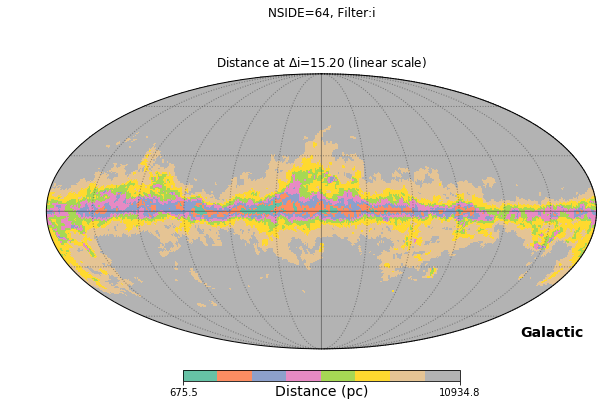

In [96]:
# test to see if our extinction methods work here...
readExtinction.testDeltamags('i', 15.2, cmap='Set2', pathMap=pathReddening)

#### Some routines we need to evaluate the saturation level ####

In [9]:
def selectBrightnessKeys(bg=None, keySat='saturation_mag', keyDepth='CoaddM5'):
    
    """Determine which keys in the bundle dict to use for our 'short' and 'long' exposures"""

    # if a bundle group was not passed in, return dummy keywords that will fail later on.
    if bg is None:
        return 'DUMMY_sat', 'DUMMY_m5'
    
    # Below, we will use the saturation limit and the m5 limiting depth from the 
    # short or long exposures as appropriate. 
    #
    # which keys we use depends on whether there actually *were* "short" as 
    # well as "long" exposures in the opsim. There's probably a sims_maf-ish way 
    # to learn this, but for the moment we just determine which does not have 
    # "None" as the metricValues. We first learn which keys correspond to the 
    # pieces we want, then find out which are populated.

    # These dictionaries are keyed by the search terms in the bundle names.
    # For clarity let's just use one dictionary each for the saturation mag
    # and for the m5 magnitude keys. Doing things this way should allow us 
    # to make changes to the search string up above (e.g. by varying the 
    # filter) and everything from here down should be unaffected.
    keySats = {'lt':'DUMMY', 'gt':'DUMMY'}
    keyMags = {'lt':'DUMMY', 'gt':'DUMMY'}

    # Look for keys that have "lt" and "saturation_mag"
    for sKey in bg.bundleDict.keys():
        for sSz in keySats.keys():
            if sKey.find(sSz) > -1:
                if sKey.find(keySat) > -1:
                    keySats[sSz] = sKey[:]
                if sKey.find(keyDepth) > -1:
                    keyMags[sSz] = sKey[:]

    # Default bundles to use: short exp for saturation and long exp for m5 depth
    keySatUse = keySats['lt'][:]
    keyM5Use = keyMags['gt'][:]

    # If the short-exposure bundle has no metricValues, switch to the long-exposure
    if bg.bundleDict[keySatUse].metricValues is None:
        keySatUse = keySats['gt'][:]

    # if the long-exposure bundle has no metricValues, switch to the short-exposure
    if bg.bundleDict[keyM5Use].metricValues is None:
        keyM5Use = keyMags['lt'][:]
        
    return keySatUse, keyM5Use

In [10]:
def evaluateBundleGroup(pathOpsim='DUMMY', outDir='satur_test', nside=64, timeCut=20., sFilter='r', \
                  doPlots=True, run_name=''):
    
    """Creates and evaluates the bundle group for a particular run"""
    
    ## Refactored from various cells in this notebook
    if not os.access(pathOpsim, os.R_OK):
        return None
    
    # if a run name was not supplied, make one up by parsing the path to the opsim
    if len(run_name) < 1:
        run_name = pathOpsim.split('/')[-1].split('_v')[0]
        
    print("####### INFO - run name:", run_name)
    
    bundleList = []
    
    # declare a few things
    stacker = SaturationStacker()
    metric = metrics.MedianMetric(col='saturation_mag')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [metrics.MedianMetric()]
    plotDict = {}
    plotFuncs = [plots.HealpixSkyMap()]
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # Now we define the bundles for the four types: short+saturation, short+m5, long+saturation, long+m5
    sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))

    sqlShort = 'filter="%s" and visitExposureTime < %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlShort,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlShort,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))
    
    # actually run things
    conn = db.OpsimDatabase(pathOpsim)
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    
    if doPlots:
        bg.plotAll(closefigs=False)
    
    # returns the bundlegroup
    return bg
    

In [11]:
# let's try a few paths for comparison. These paths are currently hardwired for DATALAB.
lBaseline = glob.glob('/sims_maf/fbs_1.7/baseline/*db')
lShort = glob.glob('/sims_maf/fbs_1.5/short_exp/*db')
lTwilight = glob.glob('/sims_maf/*/twi*_neo/*db')
lPaths = lTwilight + lBaseline + lShort

# Note: for the full lpaths above, it takes about an hour to evaluate everything. 
# When developing, probably better to use just the first couple of entries.

## shorten the list for testing the filters
lPaths = [lBaseline[1]] + lShort
lPaths = lPaths[0:2]

print("Paths for opsims:")
lPaths

Paths for opsims:


['/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.5/short_exp/short_exp_2ns_1expt_v1.5_10yrs.db']

### Try evaluating the saturation level and m5Sigma as before ###

In [12]:
# Experiment with a loop through opsims
outDir = 'satur_test'
nside = 64 
timeCut=20.
# sFilter = 'r'
lFilters = ['u', 'g', 'r', 'i', 'z', 'y']
lEvals = []
plotBundles = False 
for pathOpsim in lPaths:
    
    bundlesResults = {}
    for sFilter in lFilters:

        # Create and evaluate the bundle group for this run
        bgroup = evaluateBundleGroup(pathOpsim, outDir, nside, timeCut, sFilter, plotBundles)
    
        # Assess which sets to use for the saturation limit and the m5 depth 
        keySatUse, keyM5Use = selectBrightnessKeys(bgroup)
        
        # pass the appropriate bundles up for computing results
        bundlesResults[sFilter] = {'run_name':bgroup.bundleDict[keySatUse].runName, \
                              'saturation':bgroup.bundleDict[keySatUse], \
                              'm5depth':bgroup.bundleDict[keyM5Use] }
        
    # ok our list of runs should now work OK
    lEvals.append(bundlesResults)

####### INFO - run name: baseline_nexp2
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime > 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime < 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
####### INFO - run name: baseline_nexp2
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:309: UserWarning: One or more of the columns requested from the database was not available. Skipping constraint filter="u" and visitExposureTime > 20.0
  ' Skipping constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:313: UserWarning:  This means skipping metrics ['Median saturation_mag : u and visitExposureTime > 20.0 : HealpixSlicer', 'CoaddM5 : u and visitExposureTime > 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:309: UserWarning: One or more of the columns requested from the dat

Querying database SummaryAllProps with constraint filter="g" and visitExposureTime > 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
Querying database SummaryAllProps with constraint filter="g" and visitExposureTime < 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
####### INFO - run name: baseline_nexp2
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime < 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20.0 for columns ['numExposures', 'fil

/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:309: UserWarning: One or more of the columns requested from the database was not available. Skipping constraint filter="r" and visitExposureTime < 20.0
  ' Skipping constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:313: UserWarning:  This means skipping metrics ['Median saturation_mag : r and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : r and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:309: UserWarning: One or more of the columns requested from the dat

Querying database SummaryAllProps with constraint filter="i" and visitExposureTime < 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
Querying database SummaryAllProps with constraint filter="i" and visitExposureTime > 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
####### INFO - run name: baseline_nexp2
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="z" and visitExposureTime < 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
Querying database SummaryAllProps with constraint filter="z" and visitExposureTime > 20.0 for columns ['numExposures', 'fil

/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:309: UserWarning: One or more of the columns requested from the database was not available. Skipping constraint filter="z" and visitExposureTime < 20.0
  ' Skipping constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:313: UserWarning:  This means skipping metrics ['Median saturation_mag : z and visitExposureTime < 20.0 : HealpixSlicer', 'CoaddM5 : z and visitExposureTime < 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:309: UserWarning: One or more of the columns requested from the dat

Querying database SummaryAllProps with constraint filter="u" and visitExposureTime > 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
Querying database SummaryAllProps with constraint filter="u" and visitExposureTime < 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
####### INFO - run name: short_exp_2ns_1expt
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="g" and visitExposureTime > 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'airmass', 'fiveSigmaDepth', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']
Querying database SummaryAllProps with constraint filter="g" and visitExposureTime < 20.0 for columns ['numExposures',

In [ ]:
## Try viewing the saturation level ##

In [13]:
# let's look at the r-band for the first in the list
satThis = lEvals[0]['r']['m5depth'].metricValues
nameThis = lEvals[0]['r']['run_name']

print(satThis)

None


In [ ]:
os.access(lPaths[0], os.R_OK)

In [153]:
# why isn't this working any more... Test the bundle query piece by piece

pathOpsim = lPaths[0]

outDir = 'tmpTEST'
nside=64
timeCut = 20.
sFilter = 'r'

bundleList = []
    
# declare a few things
stacker = SaturationStacker()
metric = metrics.MedianMetric(col='saturation_mag')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [metrics.MedianMetric()]
plotDict = {}
plotFuncs = [plots.HealpixSkyMap()]
resultsDb = db.ResultsDb(outDir=outDir)
    
# Now we define the bundles for the four types: short+saturation, short+m5, long+saturation, long+m5
sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)

# try something even simpler - just the filter!
# sqlLong = 'filter="%s"' % (sFilter)

#bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
#                                             plotDict=plotDict,
#                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
#                                                stackerList=[stacker]))

# try one that doesn't include our saturation stacker, in case that's the problem
metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 summaryMetrics=summaryStats))

# do the saturation after the m5
bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
                                             plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                stackerList=[stacker]))

# actually run things
conn = db.OpsimDatabase(pathOpsim)
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20.0 for columns ['numExposures', 'filter', 'seeingFwhmEff', 'fieldRA', 'fiveSigmaDepth', 'airmass', 'visitExposureTime', 'skyBrightness', 'saturation_mag', 'fieldDec']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:309: UserWarning: One or more of the columns requested from the database was not available. Skipping constraint filter="r" and visitExposureTime > 20.0
  ' Skipping constraint %s' % constraint)
/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:313: UserWarning:  This means skipping metrics ['CoaddM5 : r and visitExposureTime > 20.0 : HealpixSlicer', 'Median saturation_mag : r and visitExposureTime > 20.0 : HealpixSlicer']
  warnings.warn(' This means skipping metrics %s' % metricsSkipped)


### Verdict 2021-04-06: the saturation stacker above doesn't work any more with the opsims we have - something may have changed... ###

**In the meantime, we try loading a saturation map from a pre-existing run.**

In [143]:
# use sims_maf to predict the apparent magnitudes for a red clump giant.
#
# The r-band absolute magnitude of about 0.55 is taken from Ruiz-Dern et al. 
# 2018, here: https://www.aanda.org/articles/aa/full_html/2018/01/aa31572-17/aa31572-17.html
absMags = sims_utils.stellarMags('K', 0.55)
print(absMags)

{'r': 0.55, 'i': 0.3703089144, 'z': 0.30538612754000005, 'y': 0.26287054484000005, 'g': 1.1581567546, 'u': 2.8747917785999997}


In [144]:
# which filter do we use throughout
sFilter = 'z'

In [145]:
# Saturation stacker doesn't seem to work any more... Can we just try loading a map???
pathmap = './satur_test/baseline_nexp1_Median_saturation_mag_%s_and_visitExposureTime_gt_20_0_HEAL.npz' % (sFilter)
with np.load(pathmap) as oldData:
    valu = oldData['metricValues']
    mask = np.asarray(oldData['mask'], dtype='bool')
    thisMetric = np.ma.masked_array(valu, mask=mask)

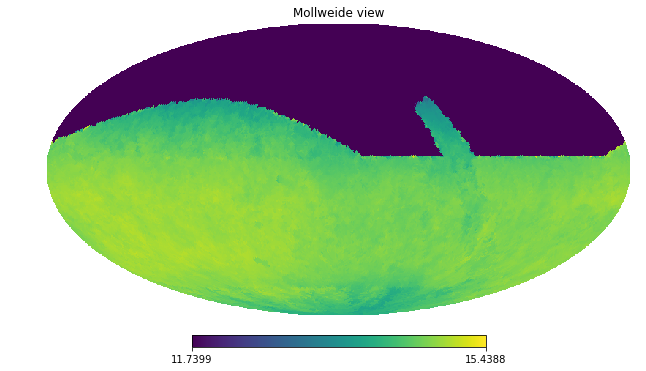

In [146]:
# Sigh... hp.mollview doesn't seem to understand what to do with masked values, 
# showing them as values of 1e20 rather than the canonical badval.
thisShow = np.ma.copy(thisMetric)
thisShow.soften_mask()
thisShow[thisShow.mask] = np.ma.min(thisShow)
thisShow.mask[~np.isfinite(thisShow)] = True
hp.mollview(thisShow)

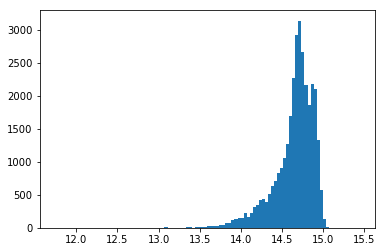

In [147]:
dum = plt.hist(thisMetric, bins=100, log=False)

In [148]:
## OK fine. Well, we now have the healpy array showing the apparent 
## magnitude at which the program exposures saturate. Let's work with that.


In [149]:
### For a given absolute magnitude, work out the delta magnitude between
### the apparent magnitudes above and the absolute magnitude
mAbs = absMags[sFilter] # about right for a red clump giant
obsMinusAbs = thisMetric - mAbs

print("Absolute magnitude at %s is %.2f" % (sFilter, mAbs))

# Now feed this as delta magnitudes to our reddening methods


Absolute magnitude at z is 0.31


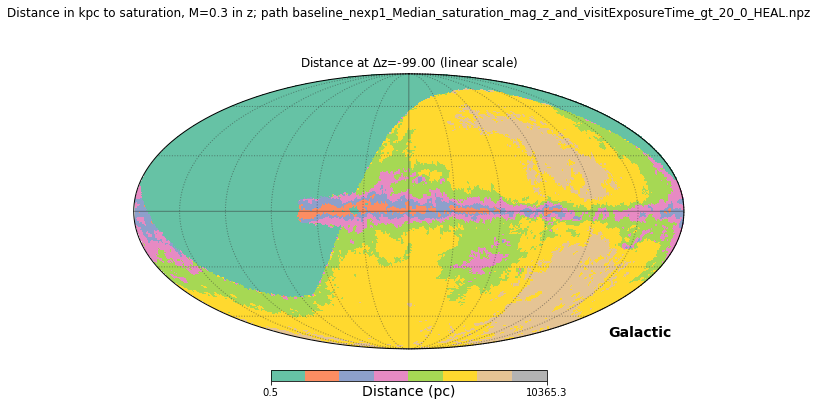

In [152]:
readExtinction.testDeltamags(sFilter, -99, cmap='Set2', pathMap=pathReddening, dmagVec=obsMinusAbs)

blah = plt.gcf().suptitle('Distance in kpc to saturation, M=%.1f in %s; path %s' \
                   % (mAbs, sFilter, os.path.split(pathmap)[-1]))

plt.gcf().savefig('test_dist2saturation_30s_%s_RCG.png' % (sFilter))

<Figure size 432x288 with 0 Axes>